M21 -  Calcule a média por nome e sobrenome do ator da seguintes variáveis:
- rental_duration
- rental_rate
- length
- replacement_cost

### Calcule a soma de amount (preço total do aluguel) por nome, sobrenome e email do cliente (customer) e indique os 10 clientes que mais gastaram e os 10 que menos gastaram.


In [ ]:
!sudo apt-get update -y
!sudo apt-get install postgresql postgresql-contrib -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Pac

In [ ]:
!sudo service postgresql start

 * Starting PostgreSQL 14 database server
   ...done.


In [ ]:
!sudo -u postgres psql -c "ALTER USER postgres PASSWORD 'senha123';"

ALTER ROLE


In [ ]:
!sudo -u postgres dropdb dvdrental --if-exists
!sudo -u postgres createdb dvdrental

NOTICE:  database "dvdrental" does not exist, skipping


In [ ]:
!sudo -u postgres pg_restore -d dvdrental /content/dvdrental.tar --verbose > restore.log 2>&1

In [1]:
# Lista as tabelas sem risco de travamento
!timeout 10 sudo -u postgres psql -d dvdrental -c "\dt"

             List of relations
 Schema |     Name      | Type  |  Owner   
--------+---------------+-------+----------
 public | actor         | table | postgres
 public | address       | table | postgres
 public | category      | table | postgres
 public | city          | table | postgres
 public | country       | table | postgres
 public | customer      | table | postgres
 public | film          | table | postgres
 public | film_actor    | table | postgres
 public | film_category | table | postgres
 public | inventory     | table | postgres
 public | language      | table | postgres
 public | payment       | table | postgres
 public | rental        | table | postgres
 public | staff         | table | postgres
 public | store         | table | postgres
(15 rows)

>8

In [2]:
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.9 MB/s eta 0:00:00


In [3]:
import psycopg2 as pg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [4]:
def connect_to_postgres():
    try:
        conn = pg2.connect(
            host="localhost",
            port=5432,
            dbname="dvdrental",
            user="postgres",
            password="senha123"
        )
        return conn
    except Exception as e:
        print("Erro ao conectar:", e)
        return None

In [12]:
sql_medias = """
SELECT
    a.first_name AS nome,
    a.last_name AS sobrenome,
    ROUND(AVG(f.rental_duration), 2) AS media_rental_duration,
    ROUND(AVG(f.rental_rate), 2)     AS media_rental_rate,
    ROUND(AVG(f.length), 2)          AS media_length,
    ROUND(AVG(f.replacement_cost), 2) AS media_replacement_cost
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
JOIN film f ON f.film_id = fa.film_id
GROUP BY a.first_name, a.last_name
ORDER BY a.first_name, a.last_name;
"""

df_medias_atores = execute_query(sql_medias)
# Convert relevant columns to numeric type
for col in ['media_rental_duration', 'media_rental_rate', 'media_length', 'media_replacement_cost']:
    df_medias_atores[col] = pd.to_numeric(df_medias_atores[col])

df_medias_atores.head()

,nome,sobrenome,media_rental_duration,media_rental_rate,media_length,media_replacement_cost
0,Adam,Grant,5.28,2.77,122.39,22.93
1,Adam,Hopper,4.86,2.81,112.27,19.49
2,Al,Garland,5.12,2.76,106.38,19.87
3,Alan,Dreyfuss,5.04,2.84,111.30,19.36
4,Albert,Johansson,5.06,3.29,126.64,22.47


In [5]:
def execute_query(query, fetch="all"):
    conn = connect_to_postgres()
    cur = conn.cursor()
    cur.execute(query)
    conn.commit()

    if fetch == "all":
        data = cur.fetchall()
    elif fetch == "one":
        data = cur.fetchone()
    else:
        data = cur.fetchmany()

    cols = [desc[0] for desc in cur.description]
    cur.close()
    conn.close()
    return pd.DataFrame(data, columns=cols)

/tmp/ipython-input-1696870344.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top15,


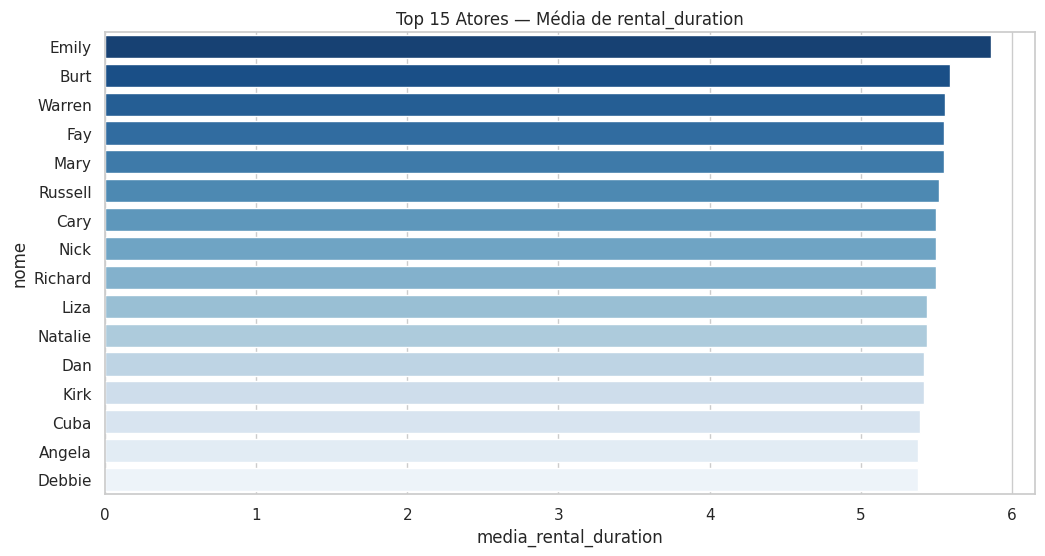

In [18]:
plt.figure(figsize=(12,6))
top15 = df_medias_atores.nlargest(15, "media_rental_duration", keep='all')

sns.barplot(data=top15,
            x="media_rental_duration",
            y="nome",
            palette="Blues_r")

plt.title("Top 15 Atores — Média de rental_duration")
plt.show()

/tmp/ipython-input-1159413370.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10,


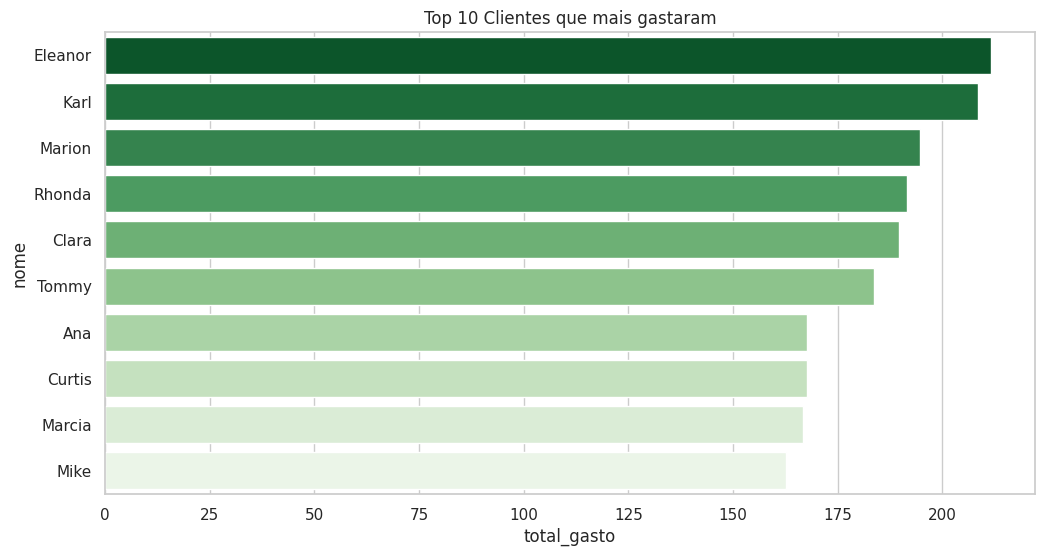

In [24]:
plt.figure(figsize=(12,6))
sns.barplot(data=top10,
            x="total_gasto",
            y="nome",
            palette="Greens_r")
plt.title("Top 10 Clientes que mais gastaram")
plt.show()

Clientes que menos gastaram

In [23]:
bottom10 = df_gastos.nsmallest(10, "total_gasto")
display(bottom10)

,nome,sobrenome,email,total_gasto
598,Brian,Wyman,brian.wyman@sakilacustomer.org,27.93
597,Leona,Obrien,leona.obrien@sakilacustomer.org,32.90
596,Caroline,Bowman,caroline.bowman@sakilacustomer.org,37.87
595,Anthony,Schwab,anthony.schwab@sakilacustomer.org,47.85
594,Tiffany,Jordan,tiffany.jordan@sakilacustomer.org,49.88
593,Kirk,Stclair,kirk.stclair@sakilacustomer.org,50.83
592,Bobbie,Craig,bobbie.craig@sakilacustomer.org,52.81
591,Jo,Fowler,jo.fowler@sakilacustomer.org,54.85
590,Penny,Neal,penny.neal@sakilacustomer.org,56.84
589,Johnny,Turpin,johnny.turpin@sakilacustomer.org,57.81


/tmp/ipython-input-341434896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10,


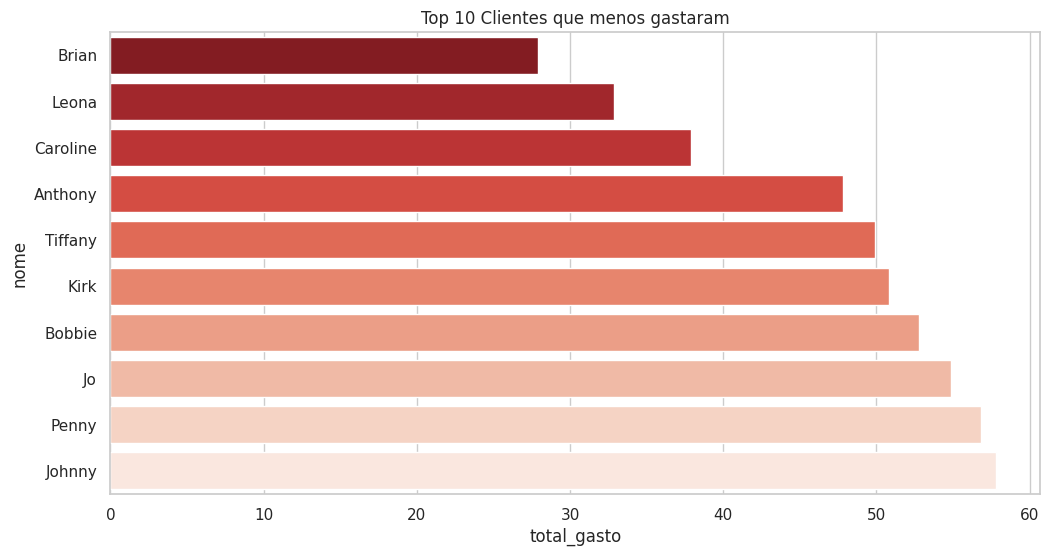

In [25]:
plt.figure(figsize=(12,6))
sns.barplot(data=bottom10,
            x="total_gasto",
            y="nome",
            palette="Reds_r")
plt.title("Top 10 Clientes que menos gastaram")
plt.show()

In [6]:
execute_query("SELECT table_name FROM information_schema.tables WHERE table_schema='public';")

,table_name
0,actor
1,actor_info
2,customer_list
3,film_list
4,nicer_but_slower_film_list
5,sales_by_film_category
6,store
7,sales_by_store
8,staff_list
9,address


In [13]:
sql = """
SELECT
    a.first_name AS nome,
    a.last_name AS sobrenome,
    AVG(f.rental_duration) AS rental_duration,
    AVG(f.rental_rate) AS rental_rate,
    AVG(f.length) AS length,
    AVG(f.replacement_cost) AS replacement_cost
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
JOIN film f ON f.film_id = fa.film_id
GROUP BY a.first_name, a.last_name
ORDER BY a.first_name, a.last_name;
"""
df_medias = execute_query(sql)
# Convert relevant columns to numeric type
for col in ['rental_duration', 'rental_rate', 'length', 'replacement_cost']:
    df_medias[col] = pd.to_numeric(df_medias[col])
df_medias

,nome,sobrenome,rental_duration,rental_rate,length,replacement_cost
0,Adam,Grant,5.277778,2.767778,122.388889,22.934444
1,Adam,Hopper,4.863636,2.808182,112.272727,19.490000
2,Al,Garland,5.115385,2.759231,106.384615,19.874615
3,Alan,Dreyfuss,5.037037,2.841852,111.296296,19.360370
4,Albert,Johansson,5.060606,3.293030,126.636364,22.474848
...,...,...,...,...,...,...
194,Will,Wilson,5.064516,3.054516,115.967742,19.957742
195,William,Hackman,4.777778,3.138148,129.074074,20.064074
196,Woody,Hoffman,4.580645,2.990000,120.838710,19.699677
197,Woody,Jolie,4.354839,2.602903,114.935484,19.409355


Top 10 clientes

In [21]:
sql_spending = """
SELECT
    c.first_name AS nome,
    c.last_name  AS sobrenome,
    c.email,
    ROUND(SUM(p.amount), 2) AS total_gasto
FROM customer c
JOIN payment p ON p.customer_id = c.customer_id
GROUP BY c.first_name, c.last_name, c.email
ORDER BY total_gasto DESC;
"""

df_gastos = execute_query(sql_spending)
# Convert 'total_gasto' to numeric type
df_gastos['total_gasto'] = pd.to_numeric(df_gastos['total_gasto'])
df_gastos.head()

,nome,sobrenome,email,total_gasto
0,Eleanor,Hunt,eleanor.hunt@sakilacustomer.org,211.55
1,Karl,Seal,karl.seal@sakilacustomer.org,208.58
2,Marion,Snyder,marion.snyder@sakilacustomer.org,194.61
3,Rhonda,Kennedy,rhonda.kennedy@sakilacustomer.org,191.62
4,Clara,Shaw,clara.shaw@sakilacustomer.org,189.60


Clientes que mais gastaram

In [22]:
top10 = df_gastos.nlargest(10, "total_gasto", keep='all')
display(top10)

,nome,sobrenome,email,total_gasto
0,Eleanor,Hunt,eleanor.hunt@sakilacustomer.org,211.55
1,Karl,Seal,karl.seal@sakilacustomer.org,208.58
2,Marion,Snyder,marion.snyder@sakilacustomer.org,194.61
3,Rhonda,Kennedy,rhonda.kennedy@sakilacustomer.org,191.62
4,Clara,Shaw,clara.shaw@sakilacustomer.org,189.60
5,Tommy,Collazo,tommy.collazo@sakilacustomer.org,183.63
6,Ana,Bradley,ana.bradley@sakilacustomer.org,167.67
7,Curtis,Irby,curtis.irby@sakilacustomer.org,167.62
8,Marcia,Dean,marcia.dean@sakilacustomer.org,166.61
9,Mike,Way,mike.way@sakilacustomer.org,162.67


/tmp/ipython-input-1294578456.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top15, x="rental_duration", y="nome", palette="Blues_r")


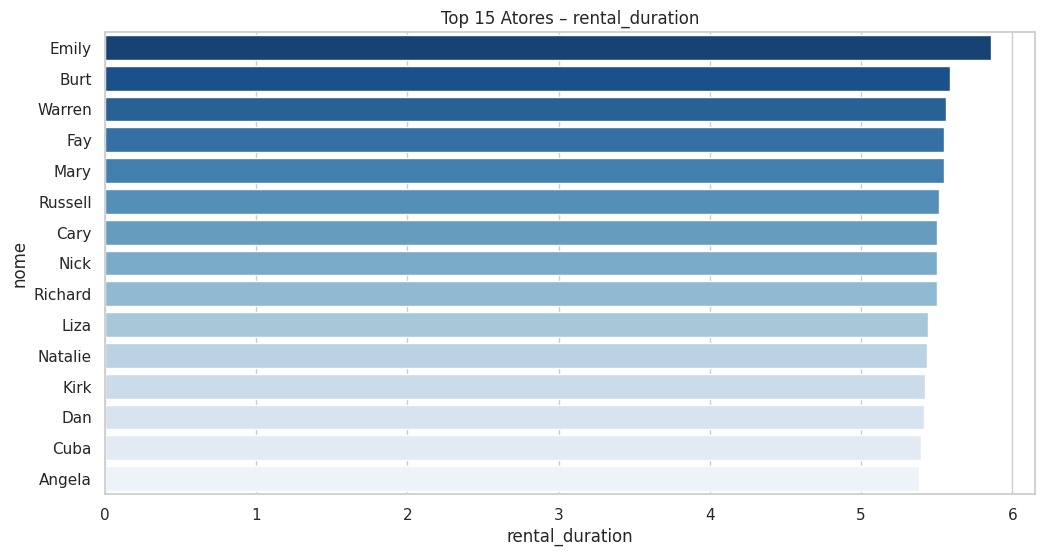

In [19]:
plt.figure(figsize=(12,6))
top15 = df_medias.nlargest(15, "rental_duration", keep='all')
sns.barplot(data=top15, x="rental_duration", y="nome", palette="Blues_r")
plt.title("Top 15 Atores – rental_duration")
plt.show()

**Conclusão**
Nesta prática, calculamos:

• Médias por ator
Usando os dados de filmes e atores, obtivemos a média de:

rental_duration
rental_rate
length
replacement_cost
Isso permitiu comparar o perfil dos filmes de cada ator.

• Clientes que mais e menos gastaram
Somamos o valor total (amount) pago por cada cliente, identificando:

Top 10 que mais gastaram
Top 10 que menos gastaram
Os gráficos facilitaram a visualização dos extremos.

A atividade reforçou o uso de SQL com PostgreSQL, consultas agregadas, joins e análise com Pandas + Seaborn.